# Grade: A3/B

### Notes: tasks 1-4 correct, task 5 fails the accuracy test (I could not understand what you wanted to do there), task 6 not implemented.
### I am not sure why you split the code into so many cells, you could have had one cell per task. You also have cells that print out/plot unnecessary staff. I have lowered you the mark for this because I found the code very confusing - you should have cleaned it up a bit.

# Checkpoint 2

In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy import integrate
from scipy.optimize import minimize_scalar
from scipy import stats

In [2]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [3]:
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 16

In [4]:
# Constants
G       = 6.67408e-11 # m^3 s^-1 kg^-2
AU      = 149.597e9 # m
Mearth  = 5.9721986e24 # kg
Mmars   = 6.41693e23 # kg
Msun    = 1.988435e30 # kg
day2sec = 3600 * 24 # seconds in one day

## Initial Conditions
Below are the initial positions and velocities for Earth and Mars.

In [5]:
# positions and velocities at t=0 (2019/6/2)
rs = [[-4.8957151e10, -1.4359284e11, 501896.65],  # Earth
      [-1.1742901e11, 2.1375285e11, 7.3558899e9]] # Mars (units of m)
vs = [[27712., -9730., -0.64148], # Earth
      [-20333., -9601., 300.34]]  # Mars (units of m/s)

## Historical Positions
Below are historical positions for Earth and Mars at t=-1000 days prior to 2019/6/2. These will be used in tasks 5 and 6.

In [6]:
# positions of the planets at (2019/6/2)-1000 days
rspast = [[1.44109e11, -4.45267e10, -509142.],   # Earth
          [1.11393e11, -1.77611e11, -6.45385e9]] # Mars

## Earth/Mars functions
Below are functions for the equations of motion (the vector of 1st derivtives) for Earth and Mars and for calculating the angle between Earth and Mars.

In [7]:
def earth_mars_motion(t, y):
    """
    # order of variables
    # 0,1,2 rx,ry,rz for Earth
    # 3,4,5 rx,ry,rz for Mars
    # 6,7,8 vx,vy,vz for Earth
    # 9,10,11 vx,vy,vz for Mars

    # order of derivatives:
    # 0,1,2 Drx,Dry,Drz for Earth
    # 3,4,5 Drx,Dry,Drz for Mars
    # 6,7,8 Dvx,Dvy,Dvz for Earth
    # 9,10,11 Dvx,Dvy,Dvy for Mars
    """

    rx1,ry1,rz1, rx2,ry2,rz2, vx1,vy1,vz1, vx2,vy2,vz2 = y
    drx1 = vx1
    dry1 = vy1
    drz1 = vz1
    drx2 = vx2
    dry2 = vy2
    drz2 = vz2
    
    GMmars  = G*Mmars
    GMearth = G*Mearth
    GMsun   = G*Msun
    
    rx12 = rx1 - rx2
    ry12 = ry1 - ry2
    rz12 = rz1 - rz2
    xy12 = np.power(np.power(rx12,2) + 2*np.power(ry12,2),1.5)
    xyz1 = np.power(np.power(rx1,2) + np.power(ry1,2) + np.power(rz1,2),1.5)
    xyz2 = np.power(np.power(rx2,2) + np.power(ry2,2) + np.power(rz2,2),1.5)

    dvx1 =  GMmars  * rx12 / xy12 - GMsun * rx1 / xyz1
    dvy1 =  GMmars  * ry12 / xy12 - GMsun * ry1 / xyz1
    dvz1 =  GMmars  * rz12 / xy12 - GMsun * rz1 / xyz1
    dvx2 = -GMearth * rx12 / xy12 - GMsun * rx2 / xyz2
    dvy2 = -GMearth * ry12 / xy12 - GMsun * ry2 / xyz2
    dvz2 = -GMearth * rz12 / xy12 - GMsun * rz2 / xyz2
    
    return np.array([drx1,dry1,drz1, drx2,dry2,drz2,
                     dvx1,dvy1,dvz1, dvx2,dvy2,dvz2])

def angle_between_planets(y):
    """
    Input should be same form as the y variable in the earth_mars_motion function.
    """
    r1 = y[0:3]
    r2 = y[3:6]
    return np.arccos((r1*r2).sum(axis=0) /
                     np.sqrt((r1*r1).sum(axis=0) * (r2*r2).sum(axis=0)))

In [8]:
def approx_angle(t,y):
    """
    Input should be same form as the y variable in the earth_mars_motion function.
    """
    r1 = y[0:3]
    r2 = y[3:6]
    result = np.arccos((r1*r2).sum(axis=0) /
                     np.sqrt((r1*r1).sum(axis=0) * (r2*r2).sum(axis=0)))
    min_angle = 0.02
    
    if result < min_angle:
        return 0
    else:
        return 1

In [9]:
def angle_between_tdep(t, ts, ys_array):
    ts = list(ts)
    index = ts.index(t)
    y = ys_array[index]
    return angle_between_planets(y)

In [10]:
def angle_rate(t,y):
    r1 = y[0:3]
    r2 = y[3:6]
    v1 = y[6:9]
    v2 = y[9:]
    
    f = (r1*r2).sum(axis=0)
    fp = (v1*r2).sum(axis=0) + (v2*r1).sum(axis=0)
    g = ((r1*r1).sum(axis=0)*(r2*r2).sum(axis=0))**0.5
    gp = (((v1*r1).sum(axis=0)*(r2*r2).sum(axis=0) + (v2*r2).sum(axis=0)*(r1*r1).sum(axis=0)) /
                ((r1*r1).sum(axis=0)*(r2*r2).sum(axis=0))**0.5)
    h = f/g
    hp = (g*fp - f*gp)/g**2
    rate = (-1/(1-h**2)**0.5)*hp
    return rate

angle_rate.direction = 1

## Task 1
Write a code that solves the equations and plots trajectories of Mars and Earth up to some $t_{max}$. The 3D plot should include at least one full orbit for each body.

In [11]:
### TASK 1
### Make plot here.
# YOUR CODE HERE
t_final = 21*365*86400 #86400 seconds in a day
N = 1000
ts = np.linspace(0, t_final, N)
delta_t = t_final/N
y_initial = np.array(rs[0] + rs[1] + vs[0] +vs[1])

In [12]:
print(y_initial)

[-4.8957151e+10 -1.4359284e+11  5.0189665e+05 -1.1742901e+11
  2.1375285e+11  7.3558899e+09  2.7712000e+04 -9.7300000e+03
 -6.4148000e-01 -2.0333000e+04 -9.6010000e+03  3.0034000e+02]


In [13]:
sol = integrate.solve_ivp(earth_mars_motion, (0, t_final), y_initial, events=(angle_rate), t_eval=ts, dense_output=True, max_step=t_final/N)
hits = sol.t_events[0]
hits = np.array(hits)

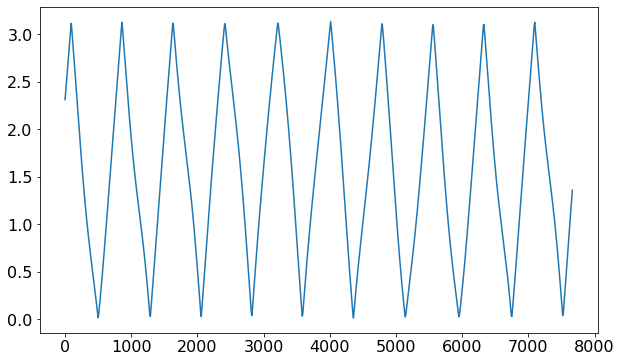

In [14]:
ys = []
for i in range(len(sol.y[0])):
    y_entry = []
    for j in range(len(sol.y)):
        y_entry.append(sol.y[j][i])
    ys.append(y_entry)
ys_array = np.array(ys)

timings = ts/86400
angles = []
for i in range(len(ys_array)):
    angles.append(angle_between_planets(ys_array[i]))
angles = np.array(angles)
plt.plot(timings, angles)

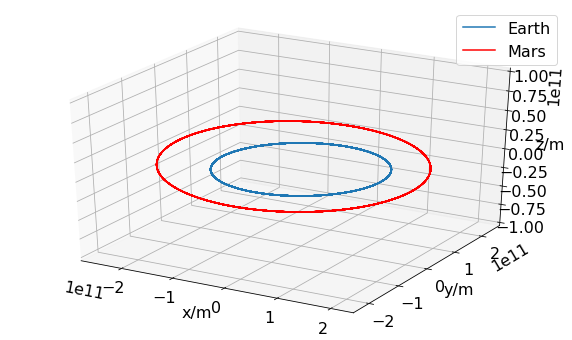

In [15]:
z_height = 10**11
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_zlim(-z_height,z_height)
ax.set_xlabel('x/m')
ax.set_ylabel('y/m')
ax.set_zlabel('z/m')
ax.plot(sol.y[0], sol.y[1], sol.y[2], label="Earth")
ax.plot(sol.y[3], sol.y[4], sol.y[5], label="Mars", color="red")
plt.legend(loc='best')

BW: correct

## Task 2
Find the time of the next opposition to $\pm10$ days. Return the time in days from $t_0$ = 2 June 2019.

In [16]:
def time_to_next_opposition():
    return hits[0]/86400

In [17]:
### TASK 2 marking cell
t_opp = time_to_next_opposition()
print (f"Next opposition in {t_opp} days.")
diff = np.abs(t_opp - 500.266)
print (f"Answer is {diff:.2f} days from correct answer.")
if diff <= 10:
    print("Correct.")
else:
    print("Incorrect.")

Next opposition in 500.25862794988143 days.
Answer is 0.01 days from correct answer.
Correct.


In [18]:
t_opp = time_to_next_opposition()
print (f"Next opposition in {t_opp} days.")

Next opposition in 500.25862794988143 days.


BW: correct

## Task 3
Find the times for 10 oppositions in days since 2 June 2019. The results must be accurate to 1 day. Convert this to dates (year/month/day) and print out on the screen. Do not worry if the dates come out different than the actual dates you can find online, it’s supposed to be like that.

The `calculate_oppositions` function should return a list of the ten next opposition times after 2 June, 2019. The times should be returned in units of days. You may create additional functions outside this cell that are called by `calculate_oppositions`.

In [19]:
def calculate_oppositions():
    return hits/86400

In [20]:
### TASK 3 marking cell

t_correct = [500.259,1285.770,2055.998,2820.898,3585.881,4356.339,5142.134,5952.572,6748.189,7522.663]

opp_times  = np.asarray(calculate_oppositions())
opp_times *= day2sec
date0      = datetime.fromisoformat('2019-06-02')
timestamp0 = datetime.timestamp(date0)

for t, tc in zip(opp_times, t_correct):
    diff = np.abs(t/day2sec - tc)
    ans = ('incorrect', 'correct')[int(diff <= 1.0)]
    print(f"t = {t/day2sec:7.2f} days: {datetime.fromtimestamp(t+timestamp0)} (diff = {diff:.2f} days) {ans}")

t =  500.26 days: 2020-10-14 06:12:25.454870 (diff = 0.00 days) correct
t = 1285.77 days: 2022-12-08 17:29:18.986118 (diff = 0.00 days) correct
t = 2056.00 days: 2025-01-16 22:57:37.584889 (diff = 0.00 days) correct
t = 2820.90 days: 2027-02-20 20:33:54.173106 (diff = 0.00 days) correct
t = 3585.88 days: 2029-03-26 21:11:00.670303 (diff = 0.00 days) correct
t = 4356.34 days: 2031-05-06 08:11:58.154825 (diff = 0.00 days) correct
t = 5142.14 days: 2033-06-30 03:19:40.201057 (diff = 0.00 days) correct
t = 5952.58 days: 2035-09-18 13:54:24.508830 (diff = 0.01 days) correct
t = 6748.20 days: 2037-11-22 03:43:41.091617 (diff = 0.01 days) correct
t = 7522.67 days: 2040-01-05 15:06:54.042103 (diff = 0.01 days) correct


In [21]:
opp_times  = calculate_oppositions()
opp_times *= day2sec
date0      = datetime.fromisoformat('2019-06-02')
timestamp0 = datetime.timestamp(date0)
for t in opp_times:
    print(f"t = {t/day2sec:.2f} day: {datetime.fromtimestamp(t+timestamp0)}")

t = 500.26 day: 2020-10-14 06:12:25.454870
t = 1285.77 day: 2022-12-08 17:29:18.986118
t = 2056.00 day: 2025-01-16 22:57:37.584889
t = 2820.90 day: 2027-02-20 20:33:54.173106
t = 3585.88 day: 2029-03-26 21:11:00.670303
t = 4356.34 day: 2031-05-06 08:11:58.154825
t = 5142.14 day: 2033-06-30 03:19:40.201057
t = 5952.58 day: 2035-09-18 13:54:24.508830
t = 6748.20 day: 2037-11-22 03:43:41.091617
t = 7522.67 day: 2040-01-05 15:06:54.042103


BW: correct

## Task 4
Estimate standard errors of these times assuming that all initial positions and velocities (12 numbers) are normally distributed random numbers with means as specified in the list of parameters, and coefficients of variation (standard deviation divided by the mean) equal to 3x10$^{-5}$.

The `estimate_errors` function should return two lists:
1. a list (or array) of the mean opposition times for 10 oppositions
2. a list (or array) of the standard deviation for each time


Units should be in days.

In [22]:
def solve1(r_data, v_data):
    y_initial = np.array(r_data[0] + r_data[1] + v_data[0] + v_data[1])
    sol = integrate.solve_ivp(earth_mars_motion, (0, t_final), y_initial, events=(angle_rate), t_eval=ts, dense_output=True, max_step=t_final/N)
    hits = sol.t_events[0]
    hits = np.array(hits)
    return hits/86400

In [23]:
# positions and velocities at t=0 (2019/6/2)
r_init = [[-4.8957151e10, -1.4359284e11, 501896.65],  # Earth
      [-1.1742901e11, 2.1375285e11, 7.3558899e9]] # Mars (units of m)
v_init = [[27712., -9730., -0.64148], # Earth
      [-20333., -9601., 300.34]]  # Mars (units of m/s)

In [24]:
print(solve1(r_init, v_init))

[ 500.25862795 1285.77035864 2055.99835168 2820.89854367 3585.88264665
 4356.34164531 5142.13865973 5952.57945033 6748.19700338 7522.67145882]


In [25]:
def samples(mean, coeff_of_v, N):
    sigma = abs(mean*coeff_of_v)
    return np.random.normal(mean, sigma, N)

In [26]:
def make_ls(data, index): #data is like all_rs
    ls = []
    for i in range(len(data)):
        ls.append(data[i][index])
    ls = np.array(ls)
    ls = np.resize(ls, (2,3))
    ls = ls.tolist()
    return ls

In [30]:
all_rs = []
N_sets = 30 #decrease if takes too long on notable
for part in rs:
    for x in part:
        xs = list(samples(x, 3*10**(-5), N_sets))
        all_rs.append(xs)
        
rs_set = []
for i in range(N_sets):
    rs_set.append(make_ls(all_rs, i))
    

In [31]:
all_vs = []
for part in vs:
    for x in part:
        xs = list(samples(x, 3*10**(-5), N_sets))
        all_vs.append(xs)
        
vs_set = []
for i in range(N_sets):
    vs_set.append(make_ls(all_vs, i))
    

In [32]:
opps_lists = []
for i in range(N_sets):
    opps = solve1(rs_set[i], vs_set[i])
    opps_lists.append(opps)
opps_array = np.array(opps_lists)
mean_opps = np.mean(opps_array, axis=0)
stdev_opps = np.std(opps_array, axis=0)
sterror_opps = stats.sem(opps_array, axis=0)

"""
#pdf says quote standard errors while notebook says quote standard deviations
#so done both here
"""

'\n#pdf says quote standard errors while notebook says quote standard deviations\n#so done both here\n'

In [33]:
def estimate_errors():
    return mean_opps,stdev_opps #replace with sterror_opps to quote standard error

#when validating error appears here but in notebook variables seem to be globally defined and it runs fine

In [34]:
### TASK 4 marking cell

tmean, tstd = estimate_errors()

tstd_correct = [0.116,0.230,0.323,0.427,0.562,0.777,1.218,1.594,1.312,1.215]

for i in range(10):
    diffm = np.abs(tmean[i] - t_correct[i])
    ansm = ('incorrect', 'correct')[int(diffm <= 1.0)]
    diffs = tstd[i] / tstd_correct[i]
    anss = ('incorrect', 'correct')[int(diffs >= 0.5 and diffs <= 1.5)]
    print(f"{i}: {tmean[i]:8.2f} +- {tstd[i]:4.2f} days. " +
          f"Mean diff: {diffm:.2f} days ({ansm}), Std diff: {diffs:.2f} ({anss})")

0:   500.26 +- 0.16 days. Mean diff: 0.00 days (correct), Std diff: 1.38 (correct)
1:  1285.78 +- 0.31 days. Mean diff: 0.01 days (correct), Std diff: 1.33 (correct)
2:  2056.01 +- 0.42 days. Mean diff: 0.01 days (correct), Std diff: 1.31 (correct)
3:  2820.92 +- 0.56 days. Mean diff: 0.02 days (correct), Std diff: 1.30 (correct)
4:  3585.91 +- 0.73 days. Mean diff: 0.03 days (correct), Std diff: 1.30 (correct)
5:  4356.37 +- 1.01 days. Mean diff: 0.03 days (correct), Std diff: 1.30 (correct)
6:  5142.15 +- 1.59 days. Mean diff: 0.02 days (correct), Std diff: 1.31 (correct)
7:  5952.57 +- 2.09 days. Mean diff: 0.00 days (correct), Std diff: 1.31 (correct)
8:  6748.22 +- 1.72 days. Mean diff: 0.03 days (correct), Std diff: 1.31 (correct)
9:  7522.71 +- 1.59 days. Mean diff: 0.05 days (correct), Std diff: 1.31 (correct)


In [97]:
tmean, tstd = estimate_errors()
for i in range(10):
    print(f"{i}: {tmean[i]:.2f} +- {tstd[i]:.2f} days.")

0: 500.26 +- 0.14 days.
1: 1285.76 +- 0.29 days.
2: 2055.98 +- 0.42 days.
3: 2820.87 +- 0.55 days.
4: 3585.85 +- 0.72 days.
5: 4356.31 +- 0.99 days.
6: 5142.12 +- 1.50 days.
7: 5952.56 +- 1.95 days.
8: 6748.15 +- 1.65 days.
9: 7522.61 +- 1.56 days.


BW: correct but maybe too many samples (20-100 would do, I changed to 30)

## Task 5
Use historical positions of Earth and Mars (boundary value problem) to improve the accuracy of your prediction. What are the standard errors now?

The `estimate_errors_improved` function should return two lists:
1. a list (or array) of the mean opposition times for 10 oppositions
2. a list (or array) of the standard deviation for each time

Units should be in days.

In [35]:
def bc(ya, yb):
    bc = []
    bc += list(np.array(ya[0:3]) - np.array(rspast[0]))
    bc += list(np.array(ya[3:6]) - np.array(rspast[1]))
    bc += list(np.array(yb[0:3]) - np.array(rs[0]))
    bc += list(np.array(yb[3:6]) - np.array(rs[1]))
    return np.array(bc)

In [36]:
def solve2(x, y):
    sol = integrate.solve_bvp(earth_mars_motion, bc, x, y, verbose=2)
    return sol

In [100]:
"""
vspast = [[8530., 25333., 0],
          [23333., 9601., 0]]
y_initial_new = np.array(rspast[0] + rspast[1] + vspast[0] +vspast[1])
t_guess = 1000*86400
Num = 1000
ts_new = np.linspace(0, t_guess, Num)
sol_guess = integrate.solve_ivp(earth_mars_motion, (0, t_guess), y_initial_new, t_eval=ts_new, dense_output=True, max_step=t_guess/Num)
"""

'\nvspast = [[8530., 25333., 0],\n          [23333., 9601., 0]]\ny_initial_new = np.array(rspast[0] + rspast[1] + vspast[0] +vspast[1])\nt_guess = 1000*86400\nNum = 1000\nts_new = np.linspace(0, t_guess, Num)\nsol_guess = integrate.solve_ivp(earth_mars_motion, (0, t_guess), y_initial_new, t_eval=ts_new, dense_output=True, max_step=t_guess/Num)\n'

In [101]:
#vs_rev = [[-27712., 9730., 0.64148],
#      [20333., 9601., -300.34]]

In [37]:
y_initial_new = np.array(rs[0] + rs[1] + vs[0] + vs[1])
t_guess = -1*1000*86400
Num = 1000
ts_new = np.linspace(0, t_guess, Num)
sol_guess = integrate.solve_ivp(earth_mars_motion, (0, t_guess), y_initial_new, t_eval=ts_new, dense_output=True, max_step=abs(t_guess/Num))

In [38]:
x = np.linspace(0, 1000*3600*24, 1000)
y = sol_guess.y
print(y)

[[-4.89571510e+10 -5.13467910e+10 -5.37218271e+10 ...  1.45778888e+11
   1.45140586e+11  1.44460297e+11]
 [-1.43592840e+11 -1.42730953e+11 -1.41828470e+11 ... -3.85582544e+10
  -4.10326757e+10 -4.34952267e+10]
 [ 5.01896650e+05  5.57302012e+05  6.12548849e+05 ... -3.33541057e+06
  -3.33092664e+06 -3.32547881e+06]
 ...
 [-2.03330000e+04 -2.04251574e+04 -2.05160530e+04 ...  2.10918622e+04
   2.12349034e+04  2.13754395e+04]
 [-9.60100000e+03 -9.43165426e+03 -9.26141051e+03 ...  1.54692468e+04
   1.52509460e+04  1.50313429e+04]
 [ 3.00340000e+02  3.06146134e+02  3.11939943e+02 ... -1.96465527e+02
  -2.04547238e+02 -2.12594441e+02]]


   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          4.15e+03       1.20e+11         1000          (1998)     
Number of nodes is exceeded after iteration 1. 
Maximum relative residual: 4.15e+03 
Maximum boundary residual: 1.20e+11


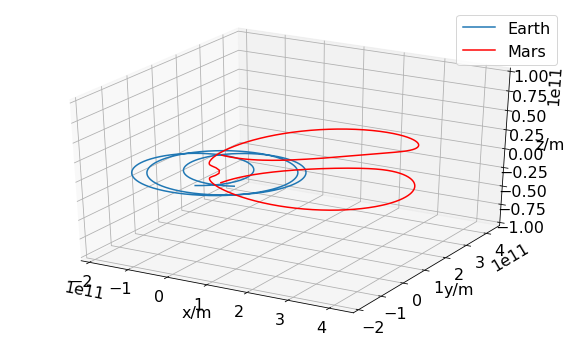

In [39]:
#guessed solution as initial value problem at t=0 going back to t=-1000 days

solb = solve2(x, y)

z_height = 10**11
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_zlim(-z_height,z_height)
ax.set_xlabel('x/m')
ax.set_ylabel('y/m')
ax.set_zlabel('z/m')
ax.plot(solb.y[0], solb.y[1], solb.y[2], label="Earth")
ax.plot(solb.y[3], solb.y[4], solb.y[5], label="Mars", color="red")
plt.legend(loc='best')

In [40]:
def estimate_errors_improved():
    return mean_opps,sterror_opps

In [41]:
### TASK 5 marking cell

tmean, tstd = estimate_errors_improved()

# t_exact are times from the real world (not meant to agree with t_correct exactly)
t_exact        = [500.114,1285.22, 2055.11, 2819.71, 3584.41, 4354.55, 5139.97, 5950.,   6745.4,  7519.63]
t_correct_impr = [500.175,1285.247,2055.094,2819.645,3584.298,4354.439,5139.941,5950.123,6745.394,7519.512]
tstd_correct_impr = [0.098,0.086,0.096,0.125,0.180,0.288,0.526,0.683,0.464,0.372]

for i in range(10):
    diffm = np.abs(tmean[i] - t_correct_impr[i])
    ansm = ('incorrect', 'correct')[int(diffm <= 1.0)]
    diffs = tstd[i] / tstd_correct_impr[i]
    anss = ('incorrect', 'correct')[int(diffs >= 0.5 and diffs <= 1.5)]
    print(f"{i}: {tmean[i]:8.2f} +- {tstd[i]:4.2f} days. " +
          f"Mean diff: {diffm:.2f} days ({ansm}), Std diff: {diffs:.2f} ({anss})")

0:   500.26 +- 0.03 days. Mean diff: 0.08 days (correct), Std diff: 0.30 (incorrect)
1:  1285.78 +- 0.06 days. Mean diff: 0.53 days (correct), Std diff: 0.66 (correct)
2:  2056.01 +- 0.08 days. Mean diff: 0.92 days (correct), Std diff: 0.82 (correct)
3:  2820.92 +- 0.10 days. Mean diff: 1.27 days (incorrect), Std diff: 0.83 (correct)
4:  3585.91 +- 0.14 days. Mean diff: 1.61 days (incorrect), Std diff: 0.75 (correct)
5:  4356.37 +- 0.19 days. Mean diff: 1.93 days (incorrect), Std diff: 0.65 (correct)
6:  5142.15 +- 0.30 days. Mean diff: 2.21 days (incorrect), Std diff: 0.56 (correct)
7:  5952.57 +- 0.39 days. Mean diff: 2.45 days (incorrect), Std diff: 0.57 (correct)
8:  6748.22 +- 0.32 days. Mean diff: 2.82 days (incorrect), Std diff: 0.69 (correct)
9:  7522.71 +- 0.30 days. Mean diff: 3.20 days (incorrect), Std diff: 0.79 (correct)


In [106]:
tmean, tstd = estimate_errors_improved()

for i in range(10):
    print(f"{i}: {tmean[i]:.2f} +- {tstd[i]:.2f} days.")

0: 500.26 +- 0.01 days.
1: 1285.76 +- 0.03 days.
2: 2055.98 +- 0.04 days.
3: 2820.87 +- 0.06 days.
4: 3585.85 +- 0.07 days.
5: 4356.31 +- 0.10 days.
6: 5142.12 +- 0.15 days.
7: 5952.56 +- 0.20 days.
8: 6748.15 +- 0.17 days.
9: 7522.61 +- 0.16 days.


BW: incorrect values - I am not sure what you tried to do here.

##  Task 6
Using the methods from Task 5, is there a better time point in the last 1000 days to get historical data for increasing the accuracy? Find such time t in the past 1000 days (-1000<$t$<0 days, where $t$=0 corresponds to 2 June 2019) which would yield a maximum error (std. deviation) of less than 0.2 days for each of the 10 oppositions.

$t$ should be a negative number, accurate to +/- 50 days.

The code for task 6 can take any form you like.

In [107]:
for i in range(10):
    print(f"{i}: {tmean[i]:.2f} +- {tstd[i]:.2f} days.")

0: 500.26 +- 0.01 days.
1: 1285.76 +- 0.03 days.
2: 2055.98 +- 0.04 days.
3: 2820.87 +- 0.06 days.
4: 3585.85 +- 0.07 days.
5: 4356.31 +- 0.10 days.
6: 5142.12 +- 0.15 days.
7: 5952.56 +- 0.20 days.
8: 6748.15 +- 0.17 days.
9: 7522.61 +- 0.16 days.
